In [314]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
import math 
from timeit import default_timer as timer
from decimal import Decimal, getcontext

In [315]:
# Example parameters
S = 100      # stock_price
K = 100      # strike prize
T = 1        # time to expiration
r = 0.05     # risk free interest rate
sigma = 0.2  # volatility
n = 100      # number of steps

# Set the precision 
getcontext().prec = 10

In [316]:
# Function calculating european-style option price acccording to Black-Scholes formula

def european_option_price(S, K, T, r, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        return call_price
    else:
        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        return put_price

In [317]:
# Function calculating american-style option price according to Binomial Option Pricing Model

def binomial_option_pricing(S, K, T, r, sigma, option_type, n):
    start = timer()

    # Defining variables of the model based on provided parameters
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize asset prices at maturity
    stock_prices = np.zeros((n + 1, n + 1))
    option_values = np.zeros((n + 1, n + 1))

    for i in range(n + 1):
        stock_prices[n, i] = S * (u ** (n - i)) * (d ** i)
        option_values[n, i] = max(0, max(0, stock_prices[n, i] - K) if option_type == 'call' else max(0, K - stock_prices[n, i]))

    # Calculate option values at earlier nodes
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            stock_prices[i, j] = S * (u ** i) * (d ** j)
            option_values[i, j] = np.exp(-r * dt) * (p * option_values[i + 1, j] + (1 - p) * option_values[i + 1, j + 1])

    end = timer()
    execution_time = Decimal(end - start)

    return option_values[0, 0], execution_time


In [333]:
# Checking how number of steps performed impacts the price of an option

def convergence_test(S, K, T, r, sigma, option_type, steps_increment, demanded_precision):
    price_with_k_steps = []
    time_of_execution = []
    stop_conv = 0
    i = 1

    prev_price = binomial_option_pricing(S, K, T, r, sigma, option_type, i)[0]

    while stop_conv < 1:
        result = binomial_option_pricing(S, K, T, r, sigma, option_type, i)
        price_with_k_steps.append(result[0])
        time_of_execution.append(result[1])

        if i > 1:
            if abs(price_with_k_steps[math.floor((i - 1) / steps_increment)] - prev_price) < Decimal(demanded_precision):
                stop_conv += 1

        prev_price = result[0]
        i += steps_increment

    number_of_steps = [Decimal(j * steps_increment) for j in range(1, len(price_with_k_steps) + 1)]
    percentage_price_change = [abs(Decimal(price_with_k_steps[j]) - Decimal(price_with_k_steps[j + 1])) / Decimal(price_with_k_steps[j]) for j in range(0, len(price_with_k_steps) - 1)]
    percentage_time_change = [abs(Decimal(time_of_execution[j]) - Decimal(time_of_execution[j + 1]) / Decimal((time_of_execution[j]))) for j in range(0, len(time_of_execution) - 1)]
    relative_increase_in_price = [Decimal(percentage_price_change[j] / percentage_time_change[j]) for j in range(0, len(percentage_price_change))]
    relative_increase_in_steps = [Decimal((number_of_steps[j] - number_of_steps[0])) for j in range(1, len(number_of_steps))]

    return number_of_steps, price_with_k_steps, time_of_execution, relative_increase_in_steps, relative_increase_in_price

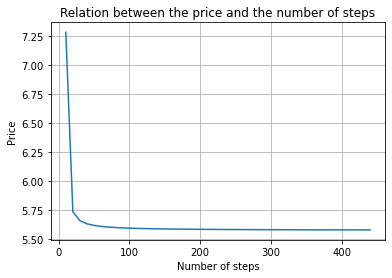

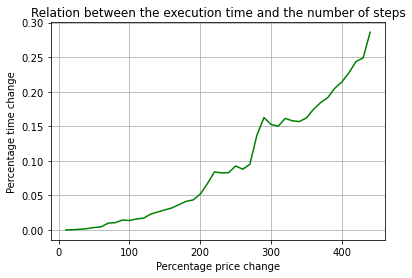

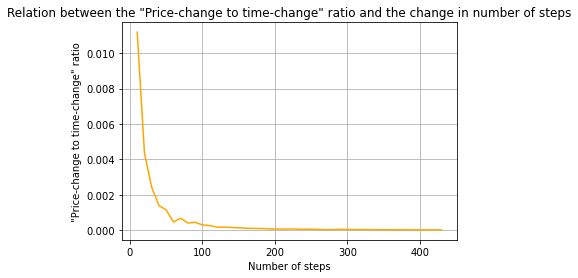

In [334]:
# Running convergence-check on a example parameters 

convergence = convergence_test(S, K, T, r, sigma, 'Call', 10, 0.0001)

# Plotting result of pricng with different number of steps

plt.plot(convergence[0], convergence[1])
plt.xlabel('Number of steps')
plt.ylabel('Price')
plt.title('Relation between the price and the number of steps')
plt.grid(True)
plt.show()

plt.plot(convergence[0], convergence[2], color='green')
plt.xlabel('Percentage price change')
plt.ylabel('Percentage time change')
plt.title('Relation between the execution time and the number of steps')
plt.grid(True)
plt.show()

plt.plot(convergence[3], convergence[4], color = 'orange')
plt.xlabel('Number of steps')
plt.ylabel('"Price-change to time-change" ratio')
plt.title('Relation between the "Price-change to time-change" ratio and the change in number of steps')
plt.grid(True)
plt.show()

In [320]:
# Calculation of "Greeks" for different options styles

def calculate_greeks_european_option(S, K, T, r, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    N_prime_d1 = norm.pdf(d1)
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    N_prime_d2 = norm.pdf(d2)

    delta = N_d1 if option_type == 'call' else N_d1 - 1
    gamma = N_prime_d1 / (S * sigma * np.sqrt(T))
    theta = -((S * N_prime_d1 * sigma) / (2 * np.sqrt(T))) - r * K * np.exp(-r * T) * N_d2
    vega = S * N_prime_d1 * np.sqrt(T)
    rho = K * T * np.exp(-r * T) * N_d2 if option_type == 'call' else -K * T * np.exp(-r * T) * N_prime_d2

    return delta, gamma, theta, vega, rho

def calculate_greeks_american_option(S, K, T, r, sigma, option_type, steps):
    epsilon = 0.0001  # A small perturbation for numerical differentiation

    # Calculate Greeks using numerical differentiation (using symmetric derivative in difference quotients)
    binomial_result_plus = binomial_option_pricing(S + epsilon, K, T, r, sigma, option_type, steps)
    binomial_result_minus = binomial_option_pricing(S - epsilon, K, T, r, sigma, option_type, steps)
    binomial_result_current = binomial_option_pricing(S, K, T, r, sigma, option_type, steps)

    delta = (binomial_result_plus[0] - binomial_result_minus[0]) / (2 * epsilon)
    gamma = (binomial_result_plus[0] - 2 * binomial_result_current[0] + binomial_result_minus[0]) / epsilon**2
    theta = (binomial_option_pricing(S, K, T - epsilon, r, sigma, option_type, steps)[0] - binomial_option_pricing(S, K, T + epsilon, r, sigma, option_type, steps)[0]) / (2 * epsilon)
    vega = (binomial_option_pricing(S, K, T, r, sigma + epsilon, option_type, steps)[0] - binomial_option_pricing(S, K, T, r, sigma - epsilon, option_type, steps)[0]) / (2 * epsilon)
    rho = (binomial_option_pricing(S, K, T, r + epsilon, sigma, option_type, steps)[0] - binomial_option_pricing(S, K, T, r - epsilon, sigma, option_type, steps)[0]) / (2 * epsilon)

    return delta, gamma, theta, vega, rho


In [321]:
# In this part of the project we will investigate the impact of the fixed set of parameters
# on the various types and styles of options.

print("Base parameters used in further calculations")
print("S = 100     :  stock_price")
print("K = 100     : strike prize")
print("T = 1       : time to expiration")
print("r = 0.05    : risk free interest rate")
print("sigma = 0.2 :  volatility")
print("n = 100     : number of steps \n")


# Results for an European  Call Option with given parameters
call_price = european_option_price(S, K, T, r, sigma, 'call')
eu_delta, eu_gamma, eu_theta, eu_vega, eu_rho = calculate_greeks_european_option(S, K, T, r, sigma, 'call')

print(f"European Call Option Price: {call_price:.4f}")
print(f"Delta for European Call Option: {eu_delta:.4f}")
print(f"Gamma for European Call Option: {eu_gamma:.4f}")
print(f"Theta for European Call Option: {eu_theta:.4f}")
print(f"Vega for European Call Option: {eu_vega:.4f}")
print(f"Rho for European Call Option: {eu_rho:.4f} \n")

# Results for an European  Call Option with given parameters
put_price = european_option_price(S, K, T, r, sigma, 'put')
eu_delta, eu_gamma, eu_theta, eu_vega, eu_rho = calculate_greeks_european_option(S, K, T, r, sigma, 'put')
print(f"European Put Option Price: {put_price:.4f}")
print(f"Delta for European Put Option: {eu_delta:.4f}")
print(f"Gamma for European Put Option: {eu_gamma:.4f}")
print(f"Theta for European Put Option: {eu_theta:.4f}")
print(f"Vega for European Put Option: {eu_vega:.4f}")
print(f"Rho for European Put Option: {eu_rho:.4f} \n")


# Results for an American Call Option with given parameters
call_price = binomial_option_pricing(S, K, T, r, sigma, 'call', n)[0]
am_delta, am_gamma, am_theta, am_vega, am_rho = calculate_greeks_american_option(S, K, T, r, sigma, 'call', n)

print(f"American Call Option Price: {call_price:.4f}")
print(f"Delta for American Option: {am_delta:.4f}")
print(f"Gamma for American Option: {am_gamma:.4f}")
print(f"Theta for American Option: {am_theta:.4f}")
print(f"Vega for American Option: {am_vega:.4f}")
print(f"Rho for American Option: {am_rho:.4f} \n")

# Results for an American option with given parameters
put_price = binomial_option_pricing(S, K, T, r, sigma, 'put', n)[0]
am_delta, am_gamma, am_theta, am_vega, am_rho = calculate_greeks_american_option(S, K, T, r, sigma, 'call', n)
print(f"American Put Option Price: {put_price:.4f}")
print(f"Delta for American Put Option: {am_delta:.4f}")
print(f"Gamma for American Put Option: {am_gamma:.4f}")
print(f"Theta for American Put Option: {am_theta:.4f}")
print(f"Vega for American Put Option: {am_vega:.4f}")
print(f"Rho for American Put Option: {am_rho:.4f} \n")

Base parameters used in further calculations
S = 100     :  stock_price
K = 100     : strike prize
T = 1       : time to expiration
r = 0.05    : risk free interest rate
sigma = 0.2 :  volatility
n = 100     : number of steps 

European Call Option Price: 10.4506
Delta for European Call Option: 0.6368
Gamma for European Call Option: 0.0188
Theta for European Call Option: -6.4140
Vega for European Call Option: 37.5240
Rho for European Call Option: 53.2325 

European Put Option Price: 5.5735
Delta for European Put Option: -0.3632
Gamma for European Put Option: 0.0188
Theta for European Put Option: -6.4140
Vega for European Put Option: 37.5240
Rho for European Put Option: -37.5240 

American Call Option Price: 10.4306
Delta for American Option: 0.6365
Gamma for American Option: 748.6004
Theta for American Option: -6.4040
Vega for American Option: 37.4300
Rho for American Option: 53.2206 

American Put Option Price: 5.5536
Delta for American Put Option: 0.6365
Gamma for American Put Option

In [322]:

# Function calculating surfaces for surface plots

def surface_option_prices(param1, param2, S, K, T, r, sigma, option_type):
    param1_values = np.linspace(0.5 * param1, 1.5 * param1, 100)
    
    if param2 == 'T':
        param2_values = np.linspace(0.1 * param2, param2, 100)
    else:
        param2_values = np.linspace(0.5 * param2, 1.5 * param2, 100)

    param1_mesh, param2_mesh = np.meshgrid(param1_values, param2_values)

    option_prices = np.zeros_like(param2_mesh)

    if (param1 == S and param2 == T):
        for i in range(len(param1_mesh)):
         for j in range(len(param2_mesh)):
                option_prices[i, j] = european_option_price(param1_mesh[i, j], K, param2_mesh[i, j], r, sigma, option_type)

    if (param1 == S and param2 == sigma):
        for i in range(len(param1_mesh)):
         for j in range(len(param2_mesh)):
                option_prices[i, j] = european_option_price(param1_mesh[i, j], K, T, r, param2_mesh[i, j], option_type)
    
    if (param1 == K and param2 == S):
        for i in range(len(param1_mesh)):
         for j in range(len(param2_mesh)):
                option_prices[i, j] = european_option_price(param2_mesh[i, j], param1_mesh[i, j], T, r, sigma, option_type)

    if (param1 == r and param2 == T):
        for i in range(len(param1_mesh)):
         for j in range(len(param2_mesh)):
                option_prices[i, j] = european_option_price(S, K, param2_mesh[i, j], param1_mesh[i, j], sigma, option_type)



    return param1_mesh, param2_mesh, option_prices



In [323]:
# Calculate option prices for surface plots (call option)

S_surface_S_T, T_surface_S_T, call_prices_S_T = surface_option_prices(S, T, S, K, T, r, sigma, 'call')
S_surface_S_sigma, sigma_surface_S_sigma, call_prices_S_sigma = surface_option_prices(S, sigma , S, K, T, r, sigma, 'call')
K_surface_K_S, S_surface_K_S, call_prices_K_S = surface_option_prices(K, S, S, K, T, r, sigma, 'call')
r_surface_r_T, T_surface_r_T, call_prices_r_T = surface_option_prices(r, T, S, K, T, r, sigma, 'call')



Text(0.5, 0.92, "Underlying Asset's Price and Time to Expiration (Call)")

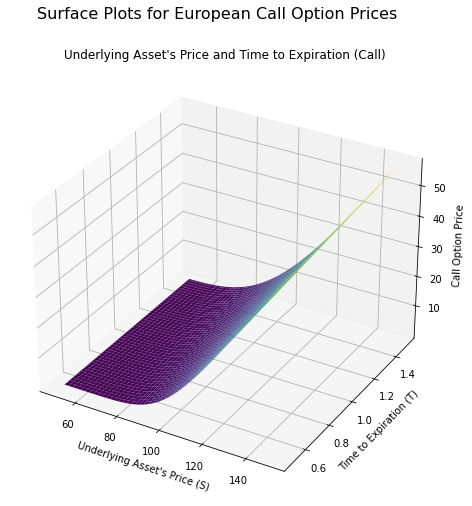

In [324]:

# Create surface plots for call options


# Plot 1: Underlying Asset's Price and Time to Expiration

fig1= plt.figure(figsize=(8, 8))
fig1.suptitle('Surface Plots for European Call Option Prices', fontsize=16)
ax = fig1.add_subplot(111, projection='3d')
ax.plot_surface(S_surface_S_T, T_surface_S_T, call_prices_S_T, cmap='viridis')
ax.set_xlabel('Underlying Asset\'s Price (S)')
ax.set_ylabel('Time to Expiration (T)')
ax.set_zlabel('Call Option Price')
ax.set_title('Underlying Asset\'s Price and Time to Expiration (Call)')


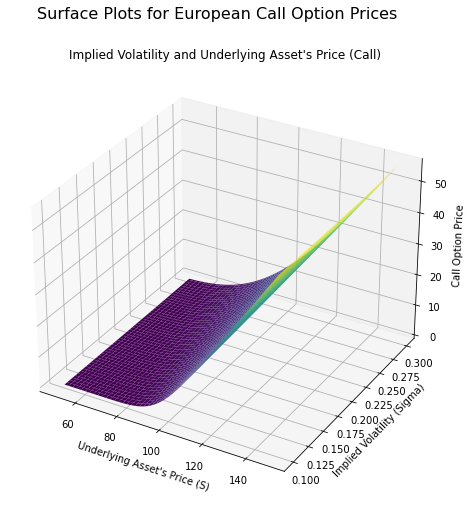

In [325]:
# Plot 2: Implied Volatility and Underlying Asset's Price

fig2 = plt.figure(figsize=(8,8))
fig2.suptitle('Surface Plots for European Call Option Prices', fontsize=16)
ax = fig2.add_subplot(111, projection='3d')
ax.plot_surface(S_surface_S_sigma, sigma_surface_S_sigma, call_prices_S_sigma, cmap='viridis')
ax.set_xlabel('Underlying Asset\'s Price (S)')
ax.set_ylabel('Implied Volatility (Sigma)')
ax.set_zlabel('Call Option Price')
ax.set_title('Implied Volatility and Underlying Asset\'s Price (Call)')
plt.show()

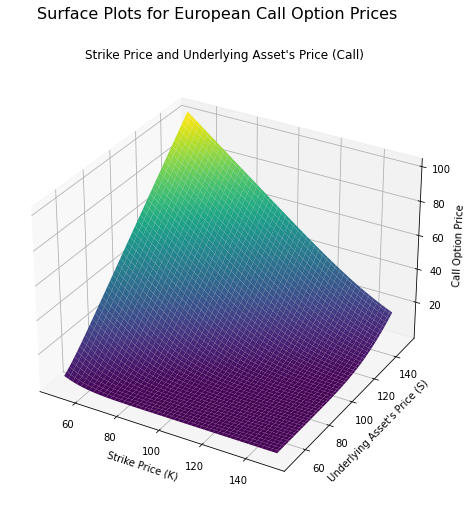

In [326]:
# Plot 3: Strike Price and Underlying Asset's Price

fig3 = plt.figure(figsize=((8,8)))
fig3.suptitle('Surface Plots for European Call Option Prices', fontsize=16)
ax = fig3.add_subplot(111, projection='3d')
ax.plot_surface(K_surface_K_S, S_surface_K_S, call_prices_K_S, cmap='viridis')
ax.set_xlabel('Strike Price (K)')
ax.set_ylabel('Underlying Asset\'s Price (S)')
ax.set_zlabel('Call Option Price')
ax.set_title('Strike Price and Underlying Asset\'s Price (Call)')
plt.show()

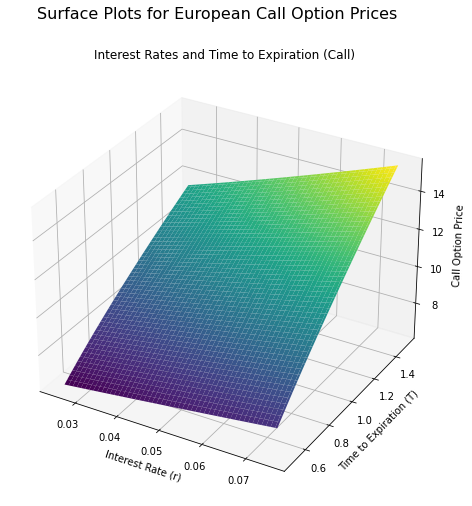

In [327]:
# Plot 4: Interest Rates and Time to Expiration

fig4 = plt.figure(figsize=(8,8))
fig4.suptitle('Surface Plots for European Call Option Prices', fontsize=16)
ax = fig4.add_subplot(111, projection='3d')
ax.plot_surface(r_surface_r_T, T_surface_r_T, call_prices_r_T, cmap='viridis')
ax.set_xlabel('Interest Rate (r)')
ax.set_ylabel('Time to Expiration (T)')
ax.set_zlabel('Call Option Price')
ax.set_title('Interest Rates and Time to Expiration (Call)')
plt.show()

In [328]:
# Calculate option prices for surface plots (put option)
S_surface_S_T, T_surface_S_T, put_prices_S_T = surface_option_prices(S, T, S, K, T, r, sigma, 'put')
S_surface_S_sigma, sigma_surface_S_sigma, put_prices_S_sigma = surface_option_prices(S, sigma, S, K, T, r, sigma, 'put')
K_surface_K_S, S_surface_K_S, put_prices_K_S = surface_option_prices(K, S, S, K, T, r, sigma, 'put')
r_surface_r_T, T_surface_r_T, put_prices_r_T = surface_option_prices(r, T, S, K, T, r, sigma, 'put')

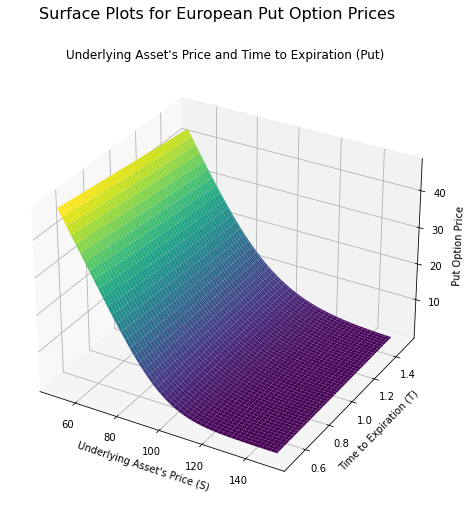

In [329]:
# Plot 5: Underlying Asset's Price and Time to Expiration

fig5 = plt.figure(figsize=(8,8))
fig5.suptitle('Surface Plots for European Put Option Prices', fontsize=16)
ax = fig5.add_subplot(111, projection='3d')
ax.plot_surface(S_surface_S_T, T_surface_S_T, put_prices_S_T, cmap='viridis')
ax.set_xlabel('Underlying Asset\'s Price (S)')
ax.set_ylabel('Time to Expiration (T)')
ax.set_zlabel('Put Option Price')
ax.set_title('Underlying Asset\'s Price and Time to Expiration (Put)')
plt.show()



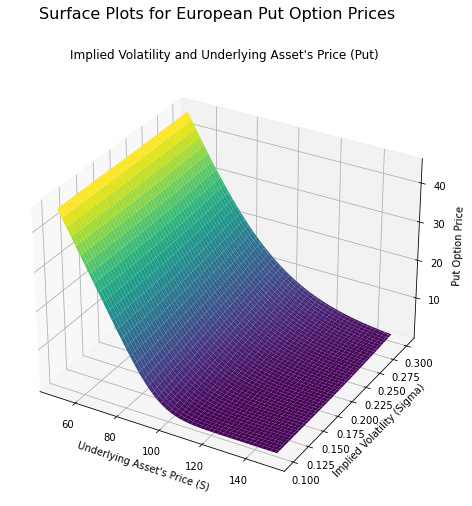

In [330]:

# Plot 6: Implied Volatility and Underlying Asset's Price

fig6 = plt.figure(figsize=(8,8))
fig6.suptitle('Surface Plots for European Put Option Prices', fontsize=16)
ax = fig6.add_subplot(111, projection='3d')
ax.plot_surface(S_surface_S_sigma, sigma_surface_S_sigma, put_prices_S_sigma, cmap='viridis')
ax.set_xlabel('Underlying Asset\'s Price (S)')
ax.set_ylabel('Implied Volatility (Sigma)')
ax.set_zlabel('Put Option Price')
ax.set_title('Implied Volatility and Underlying Asset\'s Price (Put)')
plt.show()

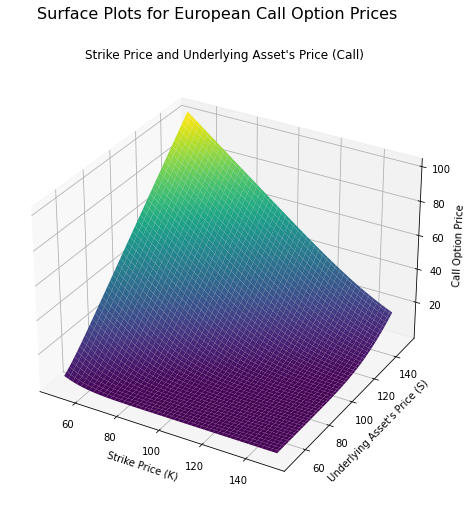

In [331]:
# Plot 7: Strike Price and Underlying Asset's Price

fig7 = plt.figure(figsize=((8,8)))
fig7.suptitle('Surface Plots for European Call Option Prices', fontsize=16)
ax = fig7.add_subplot(111, projection='3d')
ax.plot_surface(K_surface_K_S, S_surface_K_S, call_prices_K_S, cmap='viridis')
ax.set_xlabel('Strike Price (K)')
ax.set_ylabel('Underlying Asset\'s Price (S)')
ax.set_zlabel('Call Option Price')
ax.set_title('Strike Price and Underlying Asset\'s Price (Call)')
plt.show()

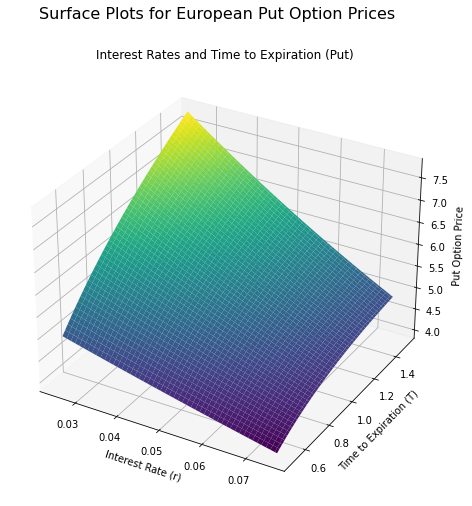

In [332]:
# Plot 8: Interest Rates and Time to Expiration

fig8 = plt.figure(figsize=(8,8))
fig8.suptitle('Surface Plots for European Put Option Prices', fontsize=16)
ax = fig8.add_subplot(111, projection='3d')
ax.plot_surface(r_surface_r_T, T_surface_r_T, put_prices_r_T, cmap='viridis')
ax.set_xlabel('Interest Rate (r)')
ax.set_ylabel('Time to Expiration (T)')
ax.set_zlabel('Put Option Price')
ax.set_title('Interest Rates and Time to Expiration (Put)')
plt.show()